In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3

from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import gc
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from os import path

import time
import sys
from tqdm import tqdm
import spacy

from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

C:\Users\This PC\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



In [2]:
#Reading data and basic stats

df = pd.read_csv("train.csv")

print("No. of data points: ",df.shape[0])

No. of data points:  404290


In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


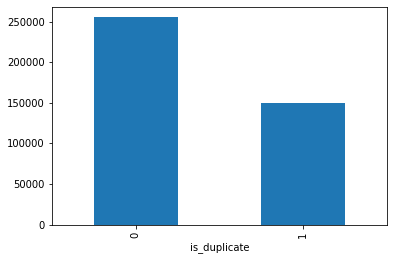

In [5]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [6]:
print('~> Total no of question pairs for training:\n {}'.format(len(df)))

~> Total no of question pairs for training:
 404290


In [7]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('~> Question pairs are Similar (is_duplicate = 1):\n {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
 63.08%
~> Question pairs are Similar (is_duplicate = 1):
 36.92%


In [8]:
#Number of unique quesitons

qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts()>1)
print('Total no of unique questions are {}\n'.format(unique_qs))

print('No. of unique questions that appears more than once: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print('Max no of times a single question is repeated: {}\n'.format(max(qids.value_counts())))

q_vals = qids.value_counts()
q_vals = q_vals.values

Total no of unique questions are 537933

No. of unique questions that appears more than once: 111780 (20.77953945937505%)

Max no of times a single question is repeated: 157



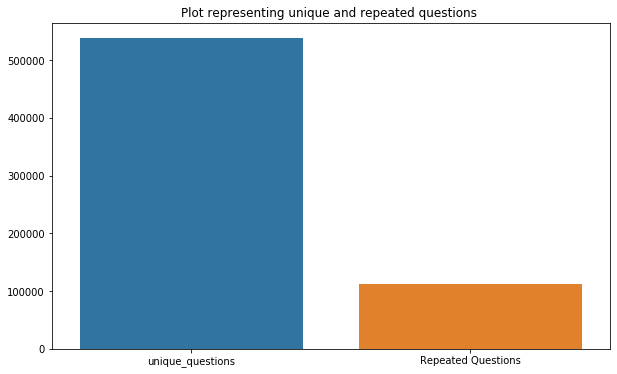

In [9]:
x = ["unique_questions", "Repeated Questions"]
y = [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title("Plot representing unique and repeated questions ")
sns.barplot(x,y)
plt.show()

In [10]:
# Checking whether there are any repeated pair of questions 

pair_duplicates = df[['qid1', 'qid2', 'is_duplicate']].groupby(['qid1', 'qid2']).count().reset_index()
print("No of duplicate questions = ",(pair_duplicates).shape[0]-df.shape[0])

No of duplicate questions =  0


Max no of times a single question is repeated : 157



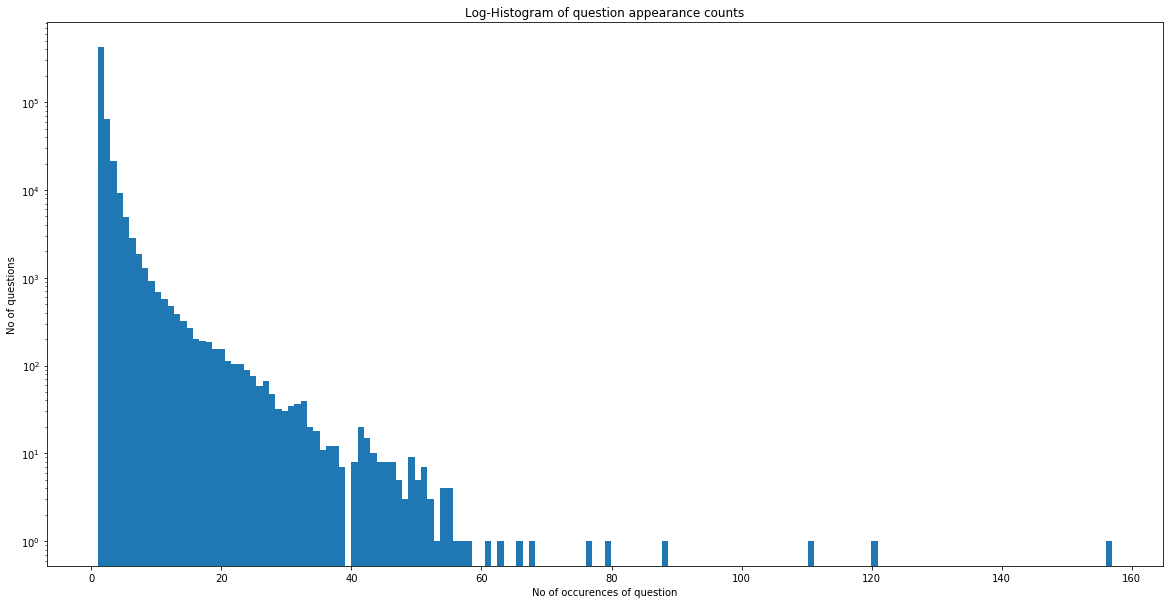

In [11]:
# Number of occurences of each question

plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('No of occurences of question')

plt.ylabel('No of questions')

print("Max no of times a single question is repeated : {}\n".format(max(qids.value_counts())))

In [12]:
# Checking for NULL values

nan_rows = df[df.isnull().any(1)]
print(nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [13]:
# Filling the null values with " "

df = df.fillna(' ')
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [14]:
# Basic Feature Extraction

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv", encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len()
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))
    
    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0*len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)
    
    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0*(len(w1)+len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)
    
    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)
    
    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])
    
    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)
    
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [15]:
# Analysis of some of the extracted features

print("Min length of questions in question1 : ", min(df['q1_n_words']))
print("Min length of questions in question2 : ", min(df['q2_n_words']))

print("No of questions with min length [question1] : ", df[df['q1_n_words']==1].shape[0])
print("No of questions with min length [question2] : ", df[df['q2_n_words']==1].shape[0])

Min length of questions in question1 :  1
Min length of questions in question2 :  1
No of questions with min length [question1] :  66
No of questions with min length [question2] :  22


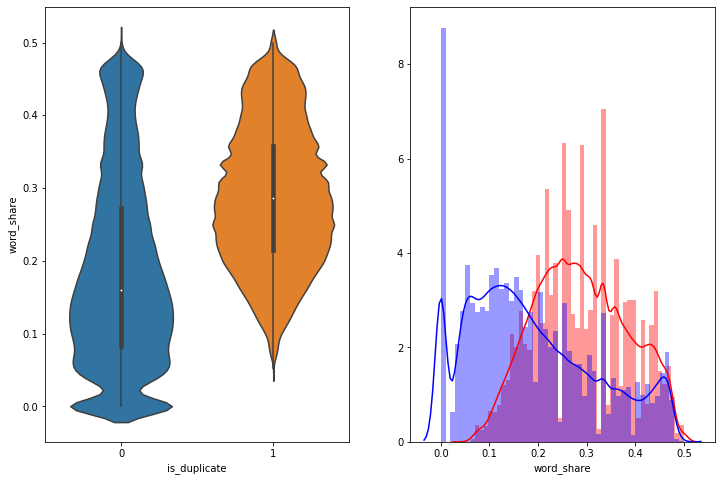

In [16]:
# Feature: word_share

plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate',y = 'word_share', data = df[0:])

plt.subplot(1,2,2)

sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:], label="1", color="red")
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:], label="0", color="blue")
plt.show()

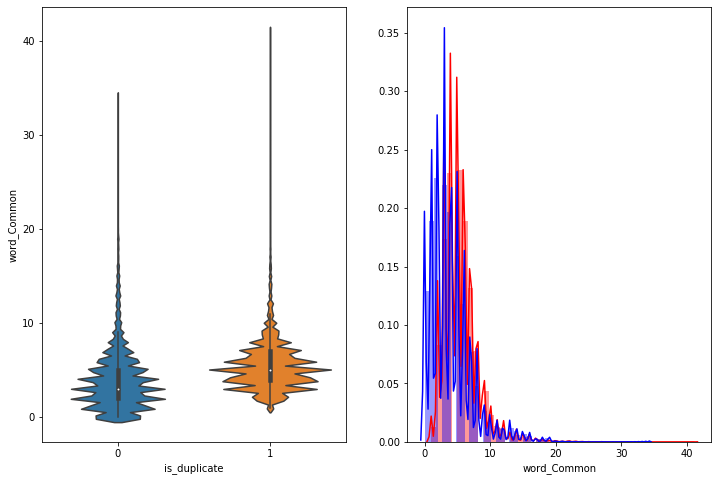

In [17]:
# Feature: word_Common

plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate',y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)

sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:], label="1", color="red")
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:], label="0", color="blue")
plt.show()

In [18]:
#Preprocessing of Text
#Removing html tags, punctuations
#Performing Stemming
#Removing Stopwords, etc

#To get the result in 4 decimal points
SAFE_DIV = 0.0001

STOP_WORDS = stopwords.words("english")

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000",r"\1m", x)
    x = re.sub(r"([0-9]+)000",r"\1k", x)
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern,' ',x)
        
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
        
    return x

In [19]:
# Advanced Feature Extraction (NLP and Fuzzy Features)

def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    #Converting the sentence into tokens
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens)==0 or len(q2_tokens)==0:
        return token_features
    #Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    #Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    #Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    #Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(q2_tokens))
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is san=me or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is san=me or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    # Average token length of both questions
    
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# Get the longest common Sub string
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)
    
def extract_features(df):
    # preprocessing each question
    df['question1'] = df["question1"].fillna("").apply(preprocess)
    df['question2'] = df["question2"].fillna("").apply(preprocess)
    
    print("Token features...")
    
    # Merging features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"] = list(map(lambda x: x[0], token_features))
    df["cwc_max"] = list(map(lambda x: x[1], token_features))
    df["csc_min"] = list(map(lambda x: x[2], token_features))
    df["csc_max"] = list(map(lambda x: x[3], token_features))
    df["ctc_min"] = list(map(lambda x: x[4], token_features))
    df["ctc_max"] = list(map(lambda x: x[5], token_features))
    df["last_word_eq"] = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"] = list(map(lambda x: x[8], token_features))
    df["mean_len"] = list(map(lambda x: x[9], token_features))
    
    # Computing fuzzy features and merging with dataset
    
    print("Fuzzy Features...")
    
    df["token_set_ratio"] = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["token_sort_ratio"] = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"] = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"] = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"] = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df


In [20]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv", encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.999980,0.999983,0.999983,...,0.916659,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.799984,0.749981,0.749981,...,0.699993,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [21]:
# Analysis of extracted features

# Plotting Word Clouds

df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print("No of data points in class 1 (duplicate pairs) :",len(p))
print("No of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s', encoding='utf-8')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s', encoding='utf-8')

No of data points in class 1 (duplicate pairs) : 298526
No of data points in class 0 (non duplicate pairs) : 510054


In [22]:
# Reading the text file and removing the stop words

d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt', ), encoding='utf-8').read()
textn_w = open(path.join(d, 'train_n.txt', ), encoding='utf-8').read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("no")
stopwords.remove("like")

print("Total no of words in duplicate pair questions :",len(textp_w))
print("Total no of words in non duplicate pair questions :",len(textn_w))

Total no of words in duplicate pair questions : 16110763
Total no of words in non duplicate pair questions : 33201102


Word Cloud for duplicate question pairs


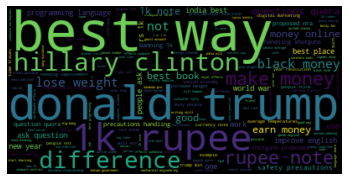

In [23]:
wc = WordCloud(max_words=len(textp_w), stopwords = stopwords)
wc.generate(textp_w)
print("Word Cloud for duplicate question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Word Cloud for non duplicate question pairs


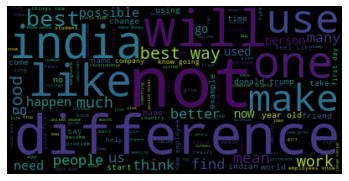

In [24]:
wc = WordCloud(max_words=len(textn_w), stopwords = stopwords)
wc.generate(textn_w)
print("Word Cloud for non duplicate question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

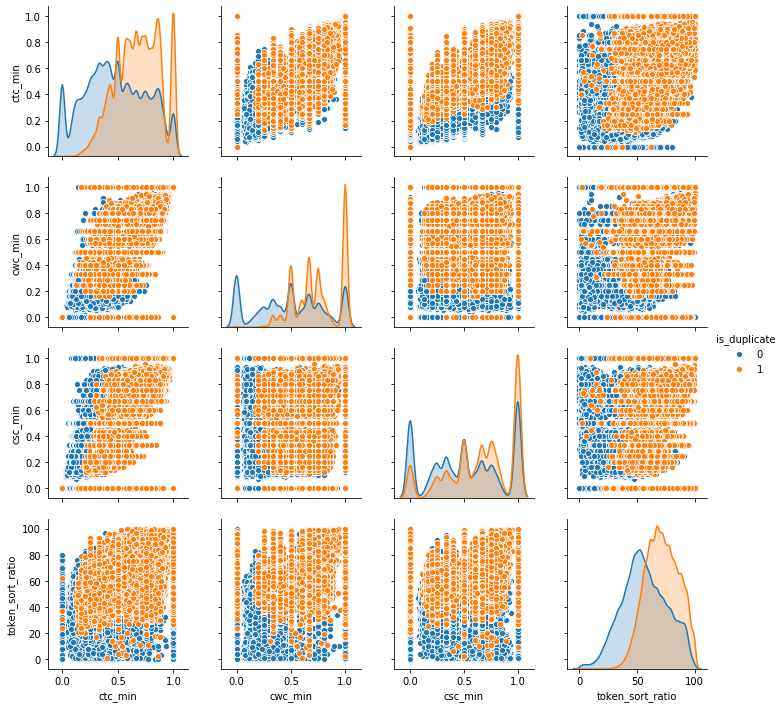

In [25]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

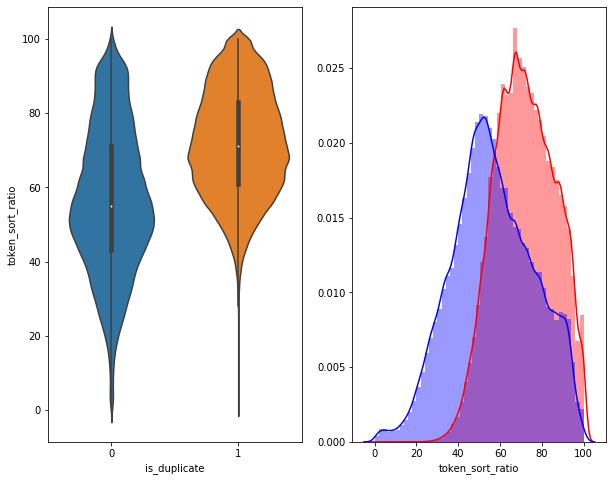

In [26]:
# Distribution of the tokoen_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:], )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:], label = "1", color='red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:], label = "0", color='blue')
plt.show()

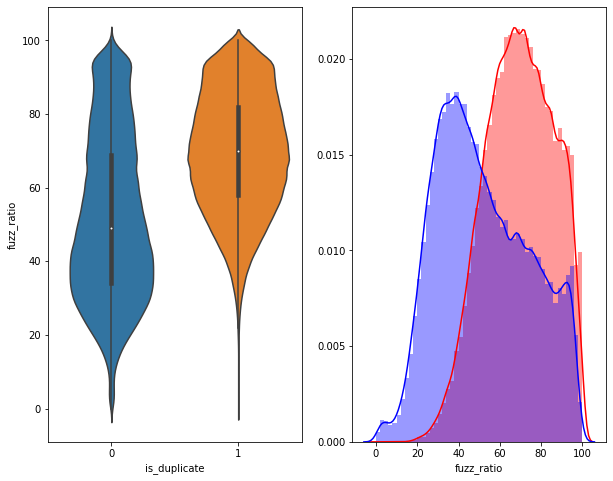

In [27]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:], )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:], label = "1", color='red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:], label = "0", color='blue')
plt.show()

In [28]:
# Visualization

# Using TSNE for Dimentionality reduction for 15 Features (Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler
dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values


In [29]:
tsne2d = TSNE(
    n_components=2,
    init='random', #pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.016s...
[t-SNE] Computed neighbors for 5000 samples in 0.470s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.117419
[t-SNE] Computed conditional probabilities in 0.355s
[t-SNE] Iteration 50: error = 80.2499542, gradient norm = 0.0399370 (50 iterations in 3.566s)
[t-SNE] Iteration 100: error = 68.7468796, gradient norm = 0.0104439 (50 iterations in 2.773s)
[t-SNE] Iteration 150: error = 66.3343430, gradient norm = 0.0066774 (50 iterations in 2.839s)
[t-SNE] Iteration 200: error = 65.2684402, gradient norm = 0.0049746 (50 iterations in 2.946s)
[t-SNE] Iteration 250: error = 64.6504440, gradient norm = 0.0036246

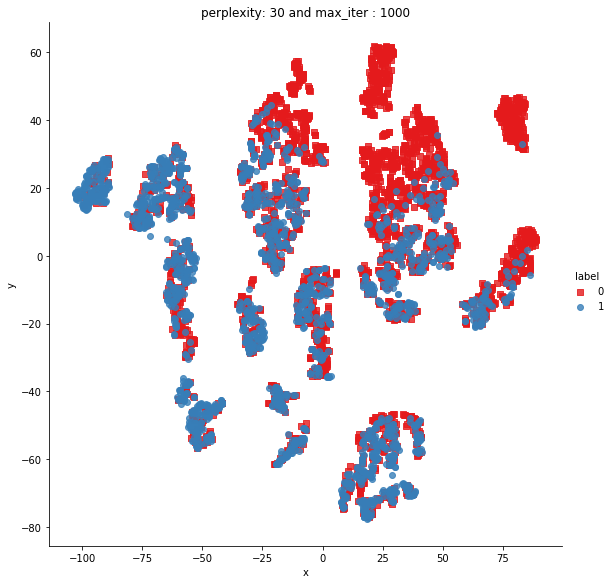

In [30]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1], 'label':y})

sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1", markers=['s','o'])
plt.title("perplexity: {} and max_iter : {}".format(30,1000))
plt.show()

In [31]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.020s...
[t-SNE] Computed neighbors for 5000 samples in 0.470s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.117419
[t-SNE] Computed conditional probabilities in 0.370s
[t-SNE] Iteration 50: error = 79.4994583, gradient norm = 0.0299280 (50 iterations in 11.370s)
[t-SNE] Iteration 100: error = 66.6772079, gradient norm = 0.0039575 (50 iterations in 4.567s)
[t-SNE] Iteration 150: error = 64.9514313, gradient norm = 0.0017295 (50 iterations in 5.816s)
[t-SNE] Iteration 200: error = 64.2367096, gradient norm = 0.0014106 (50 iterations in 5.764s)
[t-SNE] Iteration 250: error = 63.8244972, gradient norm = 0.000953

In [32]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title='duplicate'),
        line=dict(color='rgb(255,255,255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800,width=800, title='3d embedding with engineered features')
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

In [33]:
# Featurizing text data with tfidf weighted word-vectors

df = pd.read_csv("train.csv")

df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [34]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [35]:
# Merge texts

questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [36]:
import en_core_web_sm
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = en_core_web_sm.load()

vecs1 = []

#tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1)
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        #word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf=0
        #compute final vec
        mean_vec1 += vec1*idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

100%|████████████████████████████████████████████████████████████████████████| 404290/404290 [1:42:04<00:00, 66.01it/s]


In [37]:
vecs2 = []


for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2)
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        #word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            idf=0
        #compute final vec
        mean_vec2 += vec2*idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|████████████████████████████████████████████████████████████████████████| 404290/404290 [1:42:12<00:00, 65.93it/s]


In [38]:
# prepro_features_train.csv (Simple Preprocessing Features)
#nlp_features_train.csv (NLP Features)

dfnlp = pd.read_csv("nlp_features_train.csv", encoding='latin-1')
dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv", encoding='latin-1')


In [39]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index=df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index=df3.index)

In [40]:
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.999980,0.999983,0.999983,0.916659,0.916659,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.799984,0.749981,0.749981,0.699993,0.699993,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.399992,0.399992,0.399992,0.399996,0.399996,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,0,0.399992,0.399992,0.999950,0.999950,0.571420,0.571420,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [41]:
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [42]:
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,-6.179507,37.450731,-67.929894,32.224274,143.348826,135.374574,17.865208,54.562352,81.618936,232.909839,...,-71.834689,-60.222858,-22.026407,103.336720,-68.477445,-54.976584,-67.802663,116.269999,60.515897,-12.245916
1,9.236668,-80.371416,-45.785907,78.291656,183.568221,100.894077,74.344804,48.360802,127.297421,112.987302,...,-32.130515,-98.080325,19.113790,-20.507508,-76.981011,82.665075,41.085582,129.377781,115.868467,4.383543
2,97.546832,22.972194,-39.558379,18.723413,56.928618,48.307643,8.719268,36.893738,106.899947,226.283077,...,-66.835018,87.592131,4.032431,56.851710,-43.625415,-57.580962,-50.425831,78.591989,105.714355,-33.304158
3,57.586978,-22.017089,-4.599294,-88.939271,-4.732171,-54.209048,74.614947,106.533737,15.520611,39.009709,...,28.362970,41.981222,-11.204987,16.833428,-36.372476,8.927558,-64.553197,95.054246,-34.157576,70.821925
4,83.185784,-40.506985,-83.403923,-52.648658,79.074884,-19.038248,53.728722,97.648612,160.555822,290.541356,...,-4.390959,109.604406,-91.160167,-25.739913,133.123058,-13.508816,-100.115211,208.424382,286.930889,68.027638


In [43]:
df3_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,-14.616981,59.755488,-53.263745,19.514497,113.916473,101.657056,8.561499,66.232769,32.888127,210.812733,...,-72.266625,-37.072086,-31.142730,94.064854,-45.053242,-34.155221,-76.548099,99.282776,50.791731,-17.566246
1,-3.565742,-16.844571,-130.911785,0.320254,79.350278,23.562028,79.124551,84.119839,128.684135,279.539877,...,6.193171,-65.084229,-15.654534,-3.475828,26.999802,170.172613,-57.038953,194.269546,128.207803,55.490061
2,156.833630,59.991896,-8.414311,29.251426,133.680218,112.457566,89.849781,21.613022,24.331766,171.114490,...,-26.185226,-19.283218,75.602438,24.144027,-91.874398,-178.454113,-91.471482,19.922719,21.266690,49.574858
3,41.472439,56.717317,31.530616,-5.520164,33.454800,79.596179,15.508996,40.042066,21.094017,101.998116,...,-17.779019,30.152297,49.300137,27.783795,25.937188,-32.107076,-3.817634,-14.231000,4.772115,7.711628
4,-14.446975,-4.338255,-70.196208,-48.636382,18.356858,-50.807069,24.311196,60.043674,32.421993,57.148702,...,36.089472,47.193216,-49.969586,44.796028,39.740803,-33.763309,-98.282341,22.118795,68.802072,21.025373


In [44]:
print("No of features in nlp dataframe : ",df1.shape[1])
print("No of features in preprocessed dataframe : ",df2.shape[1])
print("No of features in question1 w2v dataframe : ",df3_q1.shape[1])
print("No of features in question2 w2v dataframe : ",df3_q2.shape[1])
print("No of features in final dataframe : ",df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

No of features in nlp dataframe :  17
No of features in preprocessed dataframe :  12
No of features in question1 w2v dataframe :  96
No of features in question2 w2v dataframe :  96
No of features in final dataframe :  221


In [45]:
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df2['id']
    df1 = df1.merge(df2, on='id',how='left')
    df2 = df3_q1.merge(df3_q2, on='id',how='left')
    result = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')

In [46]:
# Machine Learning Models

#Creating db file from csv
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('final_features.csv', names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y'], chunksize = chunksize, iterator=True, encoding='utf-8', ):
        df.index +=index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1


180000 rows
360000 rows
540000 rows


In [49]:
def create_connection(db_file):
    """create a database connection to the SQLite database
        spqcified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
        
    return None
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "Select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the database:")
    tables = table_names.fetchall()
    print(tables[0][0])
    return(len(tables))

In [66]:
read_db='train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the database:
data


In [67]:
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        data = pd.read_sql_query("SELECT * from data ORDER BY RANDOM() LIMIT 100001;", conn_r)
        conn_r.commit()
        conn_r.close()

In [68]:
#remove the first row
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0','id','index','is_duplicate'], axis=1, inplace=True)

In [69]:
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
1,0.999966667777741,0.999966667777741,0.999975000624984,0.999975000624984,0.999985714489793,0.999985714489793,1.0,1.0,3.0,8.5,...,-1.05544683337212,-3.87152338027954,-33.5290288329124,13.0522700250149,-20.5816159695387,-40.3010315299034,-3.13621211051941,24.1796004883945,9.33155345916748,72.0181741416454
2,0.999950002499875,0.999950002499875,0.333327777870369,0.333327777870369,0.444439506227709,0.444439506227709,0.0,0.0,12.0,15.0,...,81.5430058836937,8.95117390155792,-0.450027298182249,4.36389610171318,11.9269835352898,-7.68774580955505,-72.1102033108473,46.8775955438614,-34.9871281385422,7.06095105409622
3,0.999950002499875,0.999950002499875,0.33332222259258,0.33332222259258,0.599988000239995,0.599988000239995,0.0,1.0,12.0,11.0,...,31.1935216039419,-14.0339781045914,-58.0874003171921,222.622872978449,119.528218984604,-89.4908328056335,11.5493104457855,-0.261569559574127,92.8823767900467,38.3704421296716
4,0.999950002499875,0.999950002499875,0.999975000624984,0.999975000624984,0.999983333611106,0.999983333611106,0.0,1.0,1.0,6.5,...,17.5367283225059,14.597775220871,-21.680595010519,7.12266635894775,-21.8257567286491,-18.588020324707,-23.6147603988647,35.7940878868103,-16.1107456684113,-5.01844477653503
5,0.0,0.0,0.199996000079998,0.199996000079998,0.0769224852116522,0.0769224852116522,0.0,0.0,6.0,16.0,...,-26.8348618745804,-38.9075146913529,-7.99743014574051,37.9676592350006,-13.6147945523262,-96.4032322764397,101.449798107147,-31.7439601421356,-26.6376366615295,116.591542840004


In [70]:
# Converting string to numeric

cols = list(data.columns)
for i in cols:
    data[i] = pd.to_numeric(data[i], errors='coerce')
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
0_y
1_y
2_y
3_y
4_y
5_y
6_y
7_y
8_y
9_y
10_y
11_y
12_y
13_y
14_y
15_y
16_y
17_y
18_y
19_y
20_y
21_y
22_y
23_y
24_y
25_y
26_y
27_y
28_y
29_y
30_y
31_y
32_y
33_y
34_y
35_y
36_y
37_y
38_y
39_y
40_y
41_y
42_y
43_y
44_y
45_y
46_y
47_y
48_y
49_y

In [92]:
y_true = y_true.astype(str).astype(int)

In [93]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (70000, 218)
Number of data points in test data : (30000, 218)


In [94]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
# print(train_distr)
# print(train_len)
print("Class 0: ",int(train_distr['0'])/train_len,"Class 1: ", int(train_distr['1'])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr['1'])/test_len, "Class 1: ",int(test_distr['1'])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.0 Class 1:  0.0
---------- Distribution of output variable in test data ----------
Class 0:  0.0 Class 1:  0.0


In [122]:

# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A = (((C.T)/(C.sum(axis=1))).T)
    
    B = (C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    labelsy = [1,2]
    #cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labelsy)
    
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion Matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labelsy)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision Matrix")
    
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labelsy)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall Matrix")
    
    plt.show()

Log loss on Test data using Random Model 0.8828874530723941


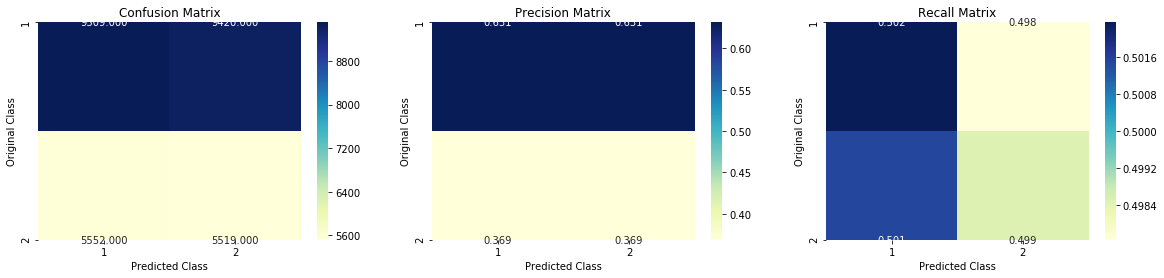

In [123]:
# Building a random model 
#Finding worst-case log-loss

predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))
predicted_y = np.argmax(predicted_y, axis=1)
# print(predicted_y)
# print(y_test)
plot_confusion_matrix(y_test, predicted_y)

For values of alpha =  1e-05 The log loss is: 0.510601121275976
For values of alpha =  0.0001 The log loss is: 0.46185814588421625
For values of alpha =  0.001 The log loss is: 0.46419368070717326
For values of alpha =  0.01 The log loss is: 0.4618815256132541
For values of alpha =  0.1 The log loss is: 0.46106108707751603
For values of alpha =  1 The log loss is: 0.48809043942085634
For values of alpha =  10 The log loss is: 0.5273349998121608


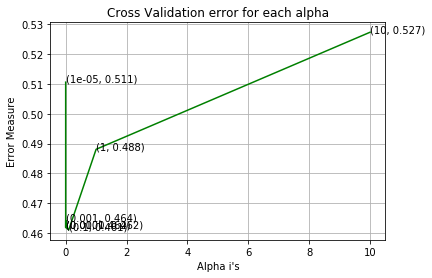

For values of best alpha =  0.1 The train log loss is:  0.45803187736626494
For values of best alpha =  0.1 The test log loss is:  0.46106108707751603
Total no of data points:  30000


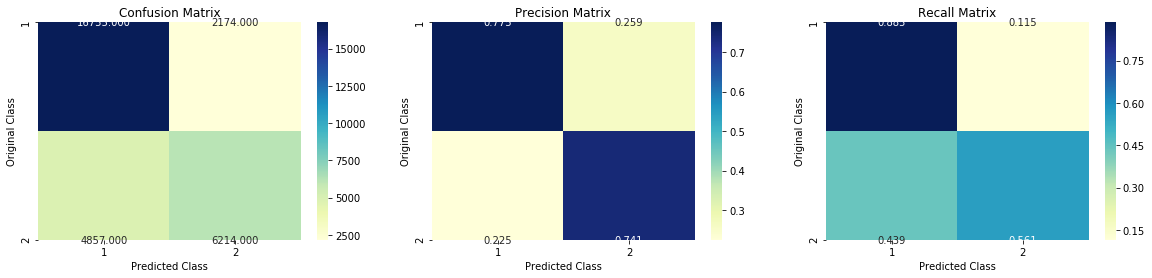

In [124]:
# Logistic Regression with hyperparamer tuning

alpha = [10 ** x for x in range(-5,2)] #hyperparam for SGD classifier

log_error_array=[]
for i in alpha:
    clf=SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf=CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ',i,"The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error Measure")
plt.show()

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train,y_train)

predict_y = sig_clf.predict_proba(X_train)
print("For values of best alpha = ",alpha[best_alpha], "The train log loss is: ",log_loss(y_train,predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print("For values of best alpha = ",alpha[best_alpha], "The test log loss is: ",log_loss(y_test,predict_y, labels=clf.classes_, eps=1e-15))
predicted_y=np.argmax(predict_y,axis=1)
print("Total no of data points: ",len(predicted_y))
plot_confusion_matrix(y_test,predicted_y)

For values of alpha =  1e-05 The log loss is: 0.6584392002466725
For values of alpha =  0.0001 The log loss is: 0.6584392002466725
For values of alpha =  0.001 The log loss is: 0.5865324225879953
For values of alpha =  0.01 The log loss is: 0.494346768198075
For values of alpha =  0.1 The log loss is: 0.5592805476235007
For values of alpha =  1 The log loss is: 0.641026704615024
For values of alpha =  10 The log loss is: 0.6520136521391112


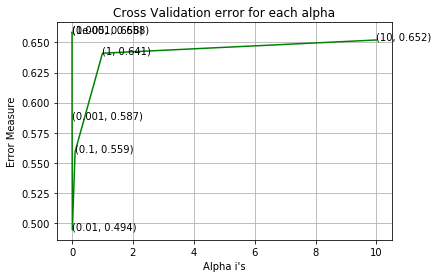

For values of best alpha =  0.01 The train log loss is:  0.4899891637668969
For values of best alpha =  0.01 The test log loss is:  0.494346768198075
Total no of data points:  30000


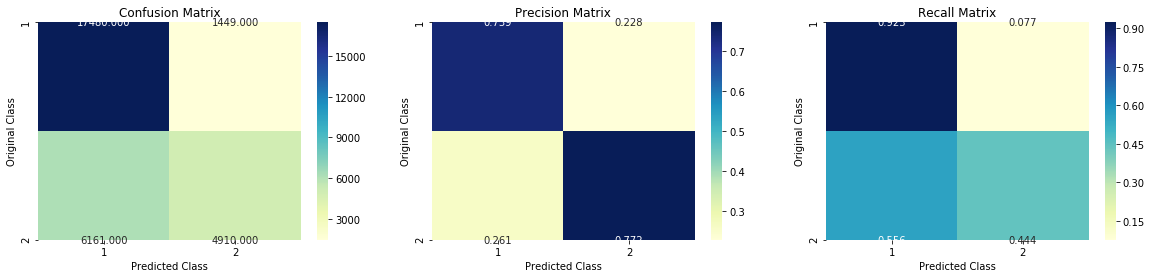

In [125]:
# Linear SVM with hyperparamer tuning

alpha = [10 ** x for x in range(-5,2)] #hyperparam for SGD classifier

log_error_array=[]
for i in alpha:
    clf=SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf=CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ',i,"The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error Measure")
plt.show()

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train,y_train)

predict_y = sig_clf.predict_proba(X_train)
print("For values of best alpha = ",alpha[best_alpha], "The train log loss is: ",log_loss(y_train,predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print("For values of best alpha = ",alpha[best_alpha], "The test log loss is: ",log_loss(y_test,predict_y, labels=clf.classes_, eps=1e-15))
predicted_y=np.argmax(predict_y,axis=1)
print("Total no of data points: ",len(predicted_y))
plot_confusion_matrix(y_test,predicted_y)

In [126]:
# XGBoost

import xgboost as xgb
params={}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test lof loss is : ",log_loss(y_test,predict_y, labels=clf.classes_,eps=1e-15))

[0]	train-logloss:0.684999	valid-logloss:0.68502
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.617358	valid-logloss:0.617621
[20]	train-logloss:0.566737	valid-logloss:0.567254
[30]	train-logloss:0.528468	valid-logloss:0.529346
[40]	train-logloss:0.499332	valid-logloss:0.500378
[50]	train-logloss:0.476686	valid-logloss:0.478011
[60]	train-logloss:0.458815	valid-logloss:0.460311
[70]	train-logloss:0.444173	valid-logloss:0.445926
[80]	train-logloss:0.432588	valid-logloss:0.434575
[90]	train-logloss:0.42304	valid-logloss:0.425296
[100]	train-logloss:0.415328	valid-logloss:0.417866
[110]	train-logloss:0.40883	valid-logloss:0.4116
[120]	train-logloss:0.403467	valid-logloss:0.406488
[130]	train-logloss:0.398602	valid-logloss:0.40189
[140]	train-logloss:0.394346	valid-logloss:0.397921
[150]	train-logloss:0.390865	valid-logloss:0.394669
[160]	train-logloss:0.387726	valid

Total no of data points:  30000


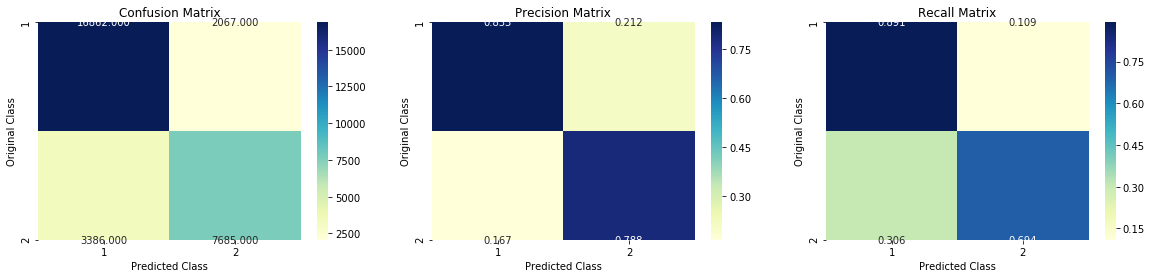

In [127]:


predicted_y = np.array(predict_y>0.5, dtype=int)
print("Total no of data points: ",len(predicted_y))
plot_confusion_matrix(y_test,predicted_y)